# <center> Predictive modelling with timeseries</center>
# <center> Part 4 - Time series forecasting with tree algorithms</center>

![Image](images/timeseries.jpg)

Even though tree algorithms (Random forests, XGBoost, CatBoost etc.) are not the first choice that comes to mind when choosing a model to start analysing a time series, they can be extremely helpful. It is important to understand the pros and cons of choosing trees to solve timeseries problems:

**PROS:** 👍🏼
* they can handle many and varied features
* they can handle small datasets  (keep in mind, one year of daily data is only 365 records)
  
**CONS:** 🥴
* they cannot extrapolate. You can't model a series with trend data, unless you make some adjustments through imputation and feature engineering.



In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# jupyter lab configs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
plotly.offline.init_notebook_mode(connected=True)

from utils import print_errors

# Exercise: Sales prediction with the Rossman dataset

# ETL

### Load the datasets

In [4]:
# training data
rossman_df = pd.read_csv('datasets/rossman_train.csv').reset_index(drop=True)
# set the index to the time column
rossman_df.Date = pd.to_datetime(rossman_df.Date)
rossman_df.head(4)

# load store info
stores = pd.read_csv('datasets/rossman_store.csv').reset_index(drop=True)
stores.head(4)

# merge store and sales
rossman_df = pd.merge(rossman_df, stores, how='left', on='Store')

# sanity check
rossman_df = rossman_df[~((rossman_df.Sales<1)&(rossman_df.Open==1))]

C:\Users\DAnand\AppData\Local\Temp\ipykernel_29636\2174550946.py:2: DtypeWarning:

Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.



,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN


General check of features

In [5]:
rossman_df.Open.unique()
rossman_df.Promo.unique()
rossman_df.StateHoliday.unique()
rossman_df.SchoolHoliday.unique()

array([1, 0], dtype=int64)

array([1, 0], dtype=int64)

array(['0', 'a', 'b', 'c', 0], dtype=object)

array([1, 0], dtype=int64)

How to deal with missing values?  
You can delete them or add them via imputation. If you decide to impute the values, don't forget to keep these values so you can apply them to the test data later 

### Add features

In [6]:
def add_time_features(df):
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['DayOfWeek'] = df.Date.dt.dayofweek
    df['WeekOfYear'] = df.Date.dt.weekofyear
    return df

def recode(df, var_list=[]):
    map_dict = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    for v in var_list:
        df[v].replace(map_dict, inplace=True)
    return df
    

### One-hot  encoding

Which features should be transformed to categorical?

Any other features you wanna try out? Add them below

In [7]:
# incorporate the new features
rossman_df = add_time_features(rossman_df)
rossman_df = recode(rossman_df, ['StoreType', 'Assortment', 'StateHoliday'])

C:\Users\DAnand\AppData\Local\Temp\ipykernel_29636\3361438179.py:6: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



---

### Split train, validation and test 

In [8]:
rossman_df.Date.min(), rossman_df.Date.max()
# make sure data is sorted by date before splitting
rossman_df = rossman_df.sort_values('Date').reset_index(drop=True)


# let's split the data into train, validation and test
# using two months of sales as test length
val_start = '2015-04-01'
test_start = '2015-06-01'
rossman_df['dataset_type'] = ''
rossman_df.loc[rossman_df.Date < val_start, 'dataset_type'] = 'train'
rossman_df.loc[rossman_df.Date.between(val_start, test_start), 'dataset_type']  = 'validation'
rossman_df.loc[rossman_df.Date >= test_start, 'dataset_type'] = 'test'

train_df = rossman_df[rossman_df.dataset_type == 'train']
val_df = rossman_df[rossman_df.dataset_type == 'validation']
test_df = rossman_df[rossman_df.dataset_type == 'test']

(Timestamp('2013-01-01 00:00:00'), Timestamp('2015-07-31 00:00:00'))

In [9]:
train_df[train_df.Date=='2013-03-28']

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,dataset_type
95883,369,3,2013-03-28,10208,832,1,1,0,1,4,...,2014.0,0,NaN,NaN,NaN,2013,3,28,13,train
95884,370,3,2013-03-28,11550,960,1,1,0,1,4,...,2000.0,1,31.0,2009.0,"Jan,Apr,Jul,Oct",2013,3,28,13,train
95885,371,3,2013-03-28,9854,715,1,1,0,1,4,...,2009.0,1,45.0,2014.0,"Feb,May,Aug,Nov",2013,3,28,13,train
95886,372,3,2013-03-28,12353,1100,1,1,0,1,4,...,2010.0,1,18.0,2014.0,"Jan,Apr,Jul,Oct",2013,3,28,13,train
95887,373,3,2013-03-28,7267,473,1,1,0,1,4,...,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct",2013,3,28,13,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96993,744,3,2013-03-28,9040,1016,1,1,0,1,1,...,2011.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct",2013,3,28,13,train
96994,745,3,2013-03-28,11669,1118,1,1,0,0,1,...,2013.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct",2013,3,28,13,train
96995,746,3,2013-03-28,7601,660,1,1,0,1,4,...,2011.0,1,35.0,2011.0,"Mar,Jun,Sept,Dec",2013,3,28,13,train
96996,747,3,2013-03-28,14500,1200,1,1,0,1,3,...,2008.0,0,NaN,NaN,NaN,2013,3,28,13,train


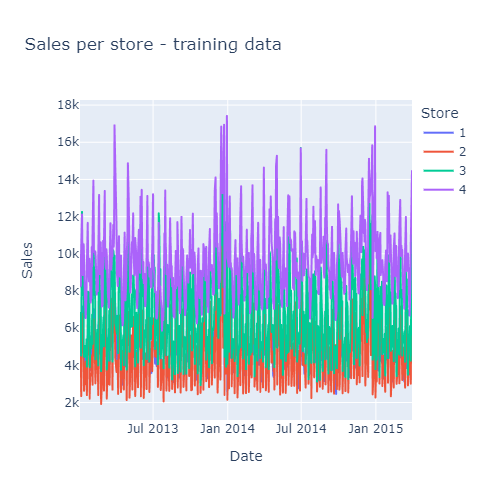

In [10]:
fig = px.line(train_df[(train_df.Store<5)&(train_df.Sales>0)], x='Date', y="Sales", color='Store', 
              title="Sales per store - training data",  width=900, height=500,
             hover_data = ['Open','Promo','StateHoliday','SchoolHoliday'])
fig.show()

---

## Create baseline and check model performance

---

## XGBoost

In [11]:
import xgboost as xgb
from xgboost import plot_importance

C:\Users\DAnand\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



In [12]:
target = 'Sales'

Create lists of sets of features, representing from a simple to a more complex model 

In [13]:
feat_dict = {'only_time' : ['Year', 'Month', 'Day', 'WeekOfYear', 'DayOfWeek', 'StateHoliday', 'SchoolHoliday', 'Open'],
             'only_comp' : ['CompetitionDistance', 'Promo2', 'Open', 'Promo'],
             'only_store' : ['StoreType', 'Assortment', 'Open'],
             'all_feat' : ['Year', 'Month', 'Day', 'WeekOfYear', 'DayOfWeek','StateHoliday', 'SchoolHoliday', 
                           'CompetitionDistance', 'Promo2', 'StoreType', 'Assortment', 'Open', 'Promo']}

In [14]:
# set the minimum parameters necessary to run XGBoost
params = {"objective": "reg:squarederror", 
          "booster" : "gbtree", 
          "seed": 10 }

In [15]:
def xgboost_experiment(vars_list, experiment_name, params, num_boost_round):
    dtrain = xgb.DMatrix(train_df[vars_list], label=train_df['Sales'])
    deval = xgb.DMatrix(val_df[vars_list], label=val_df['Sales'])
    dtest = xgb.DMatrix(test_df[vars_list], label=test_df['Sales'])
    
    #train
    xgb_model = xgb.train(params, dtrain, num_boost_round=num_boost_round, 
                      early_stopping_rounds=20, evals=[(deval, "Eval")], verbose_eval=False)

    # make prediction
    print('+++++ Results for experiment: ', experiment_name)
    pred = xgb_model.predict(dtest)
    print_errors(test_df[target], pred, 'test dataset')
    pred = xgb_model.predict(dtrain)
    print_errors(train_df[target], pred, 'train dataset') 
    return xgb_model

### Run experiments with different combinations of features

In [16]:
for f in feat_dict.keys():
    xgboost_experiment(feat_dict[f], f, params, 10)
    

C:\Users\DAnand\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

C:\Users\DAnand\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

C:\Users\DAnand\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



+++++ Results for experiment:  only_time
ERRORS in test dataset
MAE: 1749.926295999774
RMSE: 2661.7163893128763
MAPE: 27.193547882153684
RMSPE: 0.4212154085357265
ERRORS in train dataset
MAE: 1681.927254389467
RMSE: 2566.046279449853
MAPE: 28.4028674029195
RMSPE: 0.4879477782569518


C:\Users\DAnand\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

C:\Users\DAnand\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

C:\Users\DAnand\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



+++++ Results for experiment:  only_comp
ERRORS in test dataset
MAE: 1618.5724592427168
RMSE: 2438.5715201087373
MAPE: 24.82329653888103
RMSPE: 0.38636200778766916
ERRORS in train dataset
MAE: 1587.2834296983274
RMSE: 2408.057116661382
MAPE: 26.341689535289756
RMSPE: 0.45405915695941257


C:\Users\DAnand\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

C:\Users\DAnand\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

C:\Users\DAnand\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



+++++ Results for experiment:  only_store
ERRORS in test dataset
MAE: 1904.2664142181818
RMSE: 2837.073432685486
MAPE: 30.01282604522923
RMSPE: 0.47544010506664486
ERRORS in train dataset
MAE: 1844.4633302934715
RMSE: 2765.86573082389
MAPE: 31.663734310141855
RMSPE: 0.5465763610255959


C:\Users\DAnand\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

C:\Users\DAnand\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

C:\Users\DAnand\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



+++++ Results for experiment:  all_feat
ERRORS in test dataset
MAE: 1554.7814339924234
RMSE: 2355.0128674080966
MAPE: 105.4265613005316
RMSPE: 8.333604007423936
ERRORS in train dataset
MAE: 1484.2236184513981
RMSE: 2249.2550798209904
MAPE: 122.84250116796042
RMSPE: 13.940696381280993


## Run experiment with different number of trees

In [17]:
num_boost_round_list = [100, 1000, 5000]

for n in num_boost_round_list:
    print('### Experiment with ', str(n), ' boosting rounds')
    xgboost_experiment(feat_dict['all_feat'], f, params, n)
    

### Experiment with  100  boosting rounds


C:\Users\DAnand\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

C:\Users\DAnand\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

C:\Users\DAnand\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



+++++ Results for experiment:  all_feat
ERRORS in test dataset
MAE: 1060.6341391792703
RMSE: 1564.798791837305
MAPE: 4178.267714329036
RMSPE: 163.3501021548012
ERRORS in train dataset
MAE: 988.6694404221142
RMSE: 1467.5267575822827
MAPE: 5182.35629766139
RMSPE: 181.5261843507975


### Experiment with  1000  boosting rounds


C:\Users\DAnand\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

C:\Users\DAnand\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

C:\Users\DAnand\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



+++++ Results for experiment:  all_feat
ERRORS in test dataset
MAE: 807.8095659251647
RMSE: 1236.0501736625338
MAPE: 3639.526062527828
RMSPE: 141.38731547967691
ERRORS in train dataset
MAE: 687.0723838404452
RMSE: 1106.9427079271882
MAPE: 4032.4487380707615
RMSPE: 143.2396661346575


### Experiment with  5000  boosting rounds


C:\Users\DAnand\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

C:\Users\DAnand\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

C:\Users\DAnand\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



+++++ Results for experiment:  all_feat
ERRORS in test dataset
MAE: 807.8095659251647
RMSE: 1236.0501736625338
MAPE: 3639.526062527828
RMSPE: 141.38731547967691
ERRORS in train dataset
MAE: 687.0723838404452
RMSE: 1106.9427079271882
MAPE: 4032.4487380707615
RMSPE: 143.2396661346575


## Use the best set of features and another set of params

In [18]:
params = {"objective": "reg:squarederror", #since it is a regression problem
          "booster" : "gbtree",     #tree
          "eta": 0.03,              #learning rate   to reduce overfitting issues
          "max_depth": 10,          #depth of the tree
          "subsample": 0.9,         #subsample the data prior to growing trees - overcomes overfitting
          "colsample_bytree": 0.7,  #subsampling of columns for each tree
          "seed": 10                
          }

In [19]:
model1 = xgboost_experiment(feat_dict['all_feat'], 'test with different hyperparameters', params, 10)

C:\Users\DAnand\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

C:\Users\DAnand\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

C:\Users\DAnand\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



+++++ Results for experiment:  test with different hyperparameters
ERRORS in test dataset
MAE: 4609.972491926405
RMSE: 5640.939262184229
MAPE: 127.12003811675929
RMSPE: 11.550175354459444
ERRORS in train dataset
MAE: 4242.717382809162
RMSE: 5330.1684384780065
MAPE: 146.61115807252648
RMSPE: 15.33403264287255


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

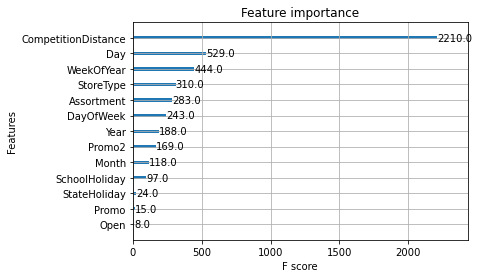

In [20]:
plot_importance(model1)

## Model evaluation

In [21]:
rossman_df['predicted'] = model1.predict(xgb.DMatrix(rossman_df[feat_dict['all_feat']]))
rossman_df['abs_error'] = np.absolute(rossman_df['predicted']  - rossman_df['Sales']) 

agg_dict = {'abs_error': ['mean', 'std']}
rossman_df.groupby('dataset_type').agg(agg_dict)

C:\Users\DAnand\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



abs_error             
                     mean          std
dataset_type                          
test          4609.972656  3250.923683
train         4242.717285  3226.461937
validation    4307.641602  3453.677319

### A good idea is to check the model error per store type and assortment

In [22]:
rossman_df[rossman_df.dataset_type=='test'].groupby(['Assortment','StoreType']).agg(agg_dict).reset_index()

Assortment StoreType     abs_error             
                                mean          std
0          1         1   4149.097168  3126.211464
1          1         2   9139.009766  5129.914800
2          1         3   4385.116211  2713.888372
3          1         4   4194.620117  2656.992467
4          2         2   7584.982910  3118.609883
5          3         1   5170.019043  3686.597252
6          3         2  14972.755859  2585.619388
7          3         3   4590.570312  3149.872782
8          3         4   4859.239258  3077.768236

### Choose a particular store and plot predictions

In [23]:
fig = px.line(rossman_df[(rossman_df.Store==379)], x='Date', y="Sales", color='dataset_type', 
              title="Sales per store - training data",  width=900, height=500,
             hover_data = ['Open','Promo','StateHoliday','SchoolHoliday'])
fig.add_trace(go.Line(x=rossman_df[(rossman_df.Store==379)].Date, y=rossman_df[(rossman_df.Store==5)].predicted,
                    mode='lines', name='predictions'))
fig.show()

C:\Users\DAnand\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




# There's a lot of room for improvement

 ### Repeat these experiments after implementing one-hot encoding, gridsearch...

---

<a href='https://www.freepik.com/vectors/business'>Business vector created by freepik - www.freepik.com</a>